In [1]:
%matplotlib inline
import os
import numpy as np
import matplotlib as mpl

import readdy_learn.analyze.analyze as ana
import readdy_learn.analyze.basis as basis
import pickle

import pynumtools.kmc as kmc

#mpl.rcParams['figure.figsize'] = (13, 13)
import matplotlib.pyplot as plt
import scipy.signal as ss
from readdy_learn.example.regulation_network import RegulationNetwork

def plot_cv_results2(cv):
    l1_dict = ana.cluster_along_arg(cv.result, "l1_ratio", cv.l1_ratios)
    alphas_dict = {}
    for l1_ratio in l1_dict.keys():
        alphas_dict[l1_ratio] = ana.cluster_along_arg(l1_dict[l1_ratio], "alpha", cv.alphas)
        
    for l1_ratio in l1_dict.keys():
        scores_mean = []
        scores_err = []
        for alpha in cv.alphas:
            cv_data = alphas_dict[l1_ratio][alpha]
            scores = []
            for d in cv_data:
                scores.append(d['scores'][0])
            scores = np.array(scores)
            scores_mean.append(np.mean(scores))
            scores_err.append(np.std(scores))
        scores_mean = np.array(scores_mean)
        scores_err = np.array(scores_err)
        print(scores_mean)
        plt.errorbar(cv.alphas, -scores_mean, yerr=scores_err, label='score l1={}'.format(l1_ratio))
    
    plt.ylabel('score')
    plt.xlabel('$\\alpha$')
    plt.xscale('log')
    plt.yscale('log')
    plt.legend()

/srv/public/miniconda3/envs/readdy_learn/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def plot_lma_traj(index):
    t = analysis.get_traj(index)
    time_range = np.linspace(0., len(t.counts[:, 0])*analysis.timestep, num=len(t.counts[:, 0]))
    plt.plot(time_range, t.counts[:, 0], label=regulation_network.species_names[0])
    plt.plot(time_range, t.counts[:, 1], label=regulation_network.species_names[1])
    plt.plot(time_range, t.counts[:, 2], label=regulation_network.species_names[2])
    plt.plot(time_range, t.counts[:, 3], label=regulation_network.species_names[3])
    plt.plot(time_range, t.counts[:, 4], label=regulation_network.species_names[4])
    plt.plot(time_range, t.counts[:, 5], label=regulation_network.species_names[5])
    plt.plot(time_range, t.counts[:, 6], label=regulation_network.species_names[6])
    plt.plot(time_range, t.counts[:, 7], label=regulation_network.species_names[7])
    plt.plot(time_range, t.counts[:, 8], label=regulation_network.species_names[8])
    plt.legend(loc="best")
    plt.show()

In [3]:
regulation_network = RegulationNetwork()
regulation_network.timestep = 6e-3
regulation_network.realisations = 1

In [4]:
analysis = regulation_network.generate_analysis_object()

In [5]:
for i in range(len(regulation_network.initial_states)):
    print("traj {}".format(i))
    t = analysis.generate_or_load_traj_lma(i, regulation_network.target_time,
                                           noise_variance=regulation_network.noise_variance,
                                           realizations=regulation_network.realisations)
    t.persist()
regulation_network.compute_gradient_derivatives(analysis)

traj 0
traj 1
traj 2
traj 3


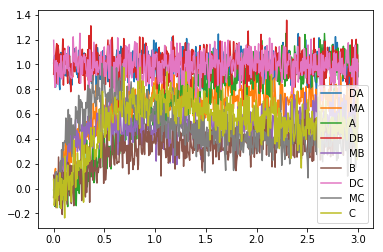

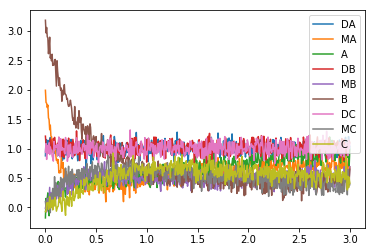

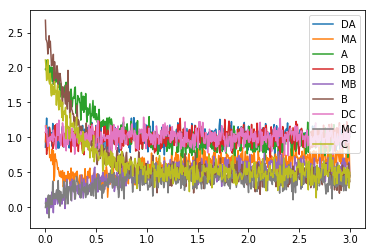

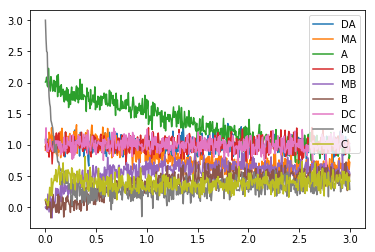

In [6]:
plot_lma_traj(0)
plot_lma_traj(1)
plot_lma_traj(2)
plot_lma_traj(3)

In [7]:
print("noise variance: {}".format(regulation_network.noise_variance))
print("target time: {}".format(regulation_network.target_time))
print("lma realizations: {}".format(regulation_network.realisations))
print("timestep: {}".format(regulation_network.timestep))
print("initial states:")
for init in regulation_network.initial_states:
    print("\t{}".format(init))

noise variance: 0.01
target time: 3.0
lma realizations: 1
timestep: 0.006
initial states:
	[[1 0 0 1 0 0 1 0 0]]
	[[1 2 0 1 0 3 1 0 0]]
	[[1.  1.  2.  1.  0.  2.5 1.  0.  2. ]]
	[[1 1 2 1 0 0 1 3 0]]


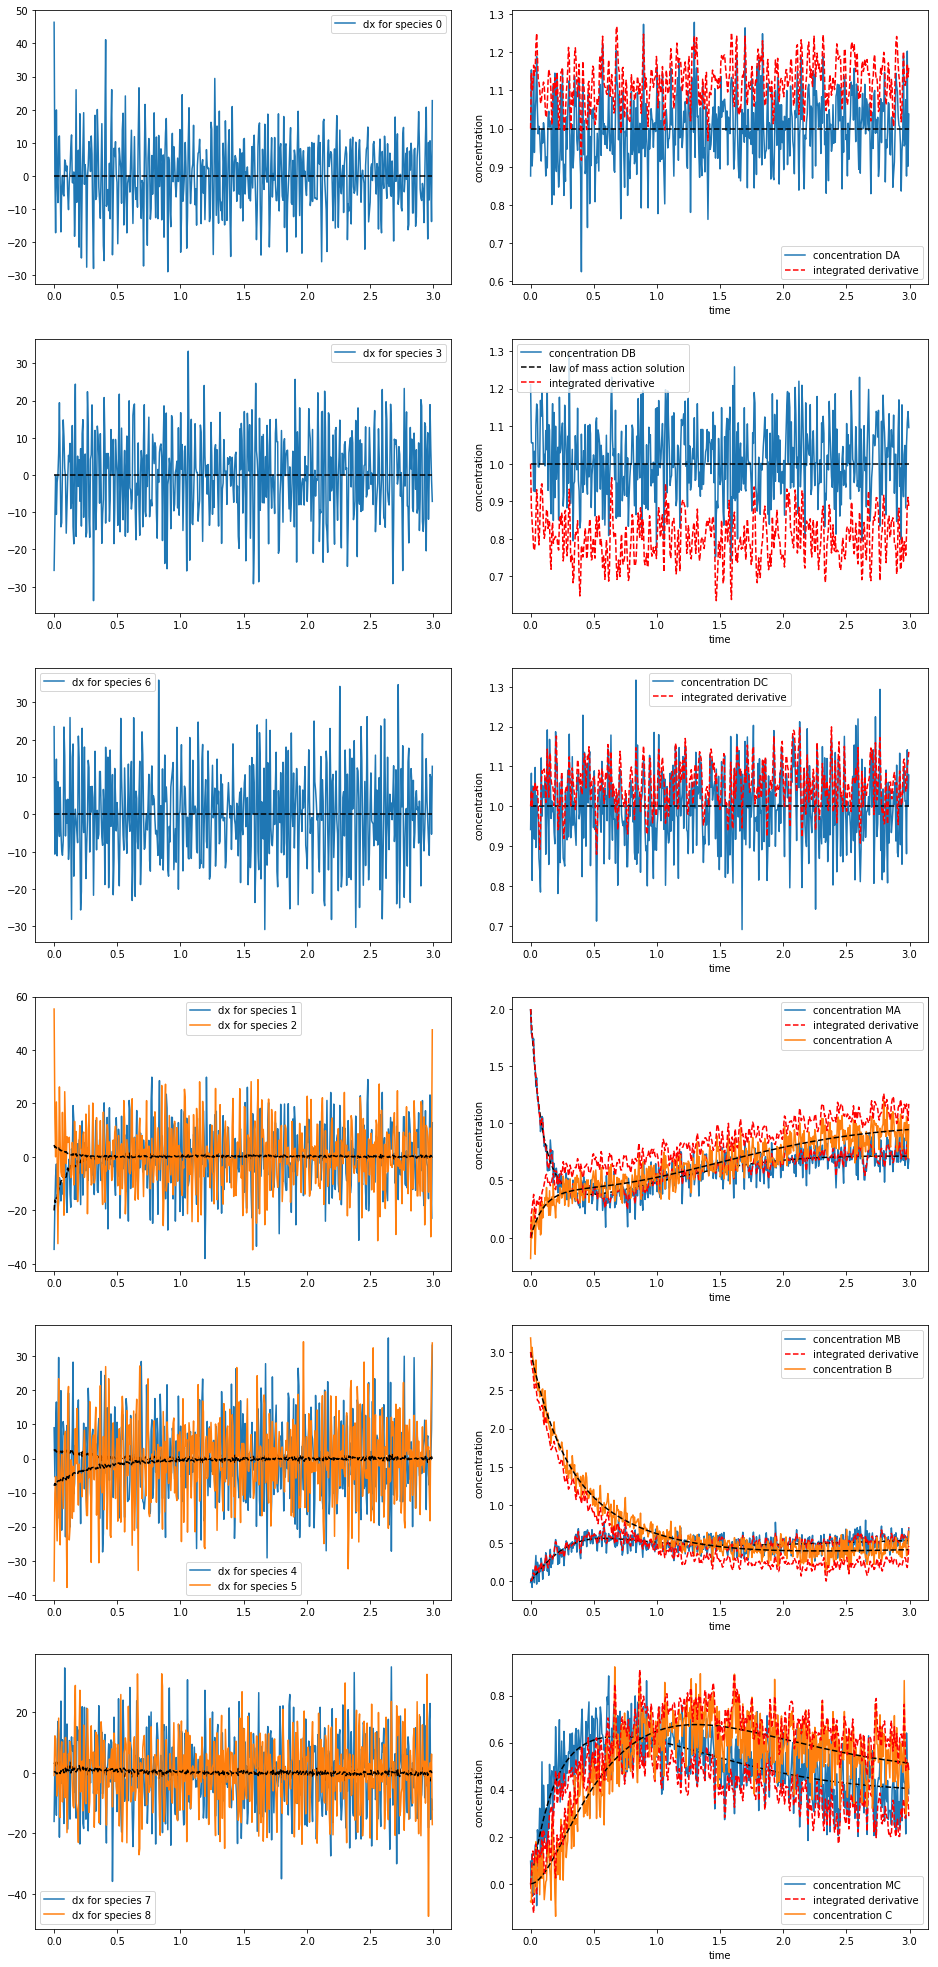

In [9]:
regulation_network.plot_concentrations(analysis, 1)

In [10]:
#alphas = np.logspace(-5., 0., num=20)
alphas = np.logspace(-5., 0., num=3)
# l1_ratios = np.linspace(0., 1., num=3)
l1_ratios = np.array([1.0])

In [11]:
cv_res = analysis.elastic_net_cv([1, 2], alphas=alphas, l1_ratios=l1_ratios, 
                                 recompute=False, tol=1e-12)

HBox(children=(HBox(children=(Label(value=' 0'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, max=6), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='flex', width='100%'))

[-620.2767029  -620.07736778 -616.99497758]


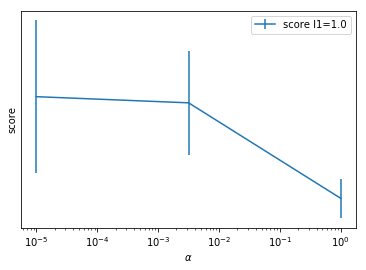

In [12]:
plot_cv_results2(cv_res)

In [13]:
alpha, l1_ratio, score = ana.best_params(cv_res)
print("got alpha={}, l1_ratio={}, score={}".format(alpha, l1_ratio, score))

-620.2767029011558
-620.0773677828661
-616.994977583711
got alpha=1.0, l1_ratio=1.0, score=616.994977583711


In [14]:
rates = analysis.solve([1, 2], alpha, l1_ratio, tol=1e-14)

optimization problem did exit successfully (alpha=1.0, lambda=1.0)!
status 0: Optimization terminated successfully.
12 / 30000 iterations


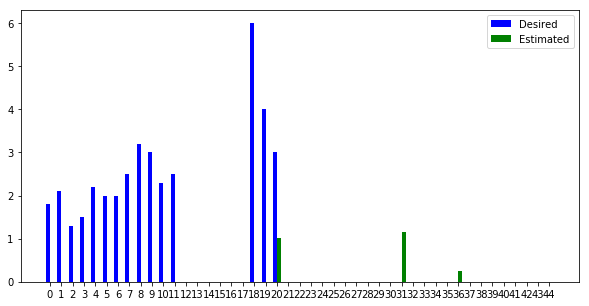

In [15]:
ana.plot_rates_bar(regulation_network.desired_rates, rates)
#plt.title("L1 regularization")

optimization problem did exit successfully (alpha=0.0, lambda=1.0)!
status 0: Optimization terminated successfully.
81 / 30000 iterations


Text(0.5,1,'Least-squares')

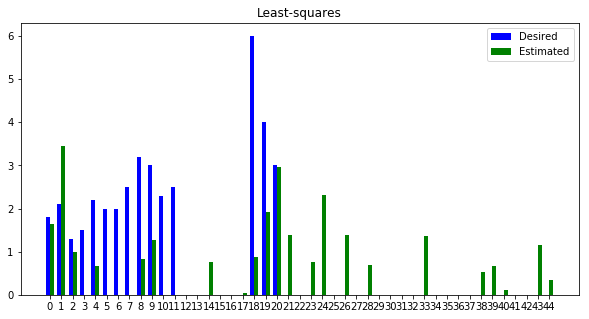

In [16]:
lsq_rates = analysis.least_squares([0, 1], tol=1e-14, recompute=True)
ana.plot_rates_bar(regulation_network.desired_rates, lsq_rates)
plt.title("Least-squares")

In [17]:
np.sum(rates)

2.417635369338659

In [18]:
np.sum(lsq_rates)

26.09838843674076

In [19]:
np.sum(regulation_network.desired_rates)

39.400000000000006

In [6]:
def do_n(n):
    traj_indices = [1, 2]
    regulation_network = RegulationNetwork()
    regulation_network.timestep = 6e-2
    regulation_network.noise_variance = 1e-4 / n
    regulation_network.realisations = 1.
    print("noise variance {}".format(regulation_network.noise_variance))
    
    analysis = regulation_network.generate_analysis_object(fname_prefix="case2", fname_postfix=str(n))
    
    for i in range(len(regulation_network.initial_states)):
        print("traj {}".format(i))
        t = analysis.generate_or_load_traj_lma(i, regulation_network.target_time,
                                               noise_variance=regulation_network.noise_variance,
                                               realizations=regulation_network.realisations)
        t.persist()
    regulation_network.compute_gradient_derivatives(analysis)
    
    print("noise variance: {}".format(regulation_network.noise_variance))
    print("target time: {}".format(regulation_network.target_time))
    print("lma realizations: {}".format(regulation_network.realisations))
    print("timestep: {}".format(regulation_network.timestep))
    print("initial states:")
    for init in regulation_network.initial_states:
        print("\t{}".format(init))
    
    alphas = np.logspace(-5., 0., num=20)
    l1_ratios = np.linspace(0., 1., num=6)
    #alphas = np.logspace(-5, 0, num=3)
    #l1_ratios = np.linspace(0.,1., num=2)
    cv_res = analysis.elastic_net_cv(traj_indices, alphas=alphas, l1_ratios=l1_ratios, 
                                 recompute=False, tol=1e-12)
    
    alpha, l1_ratio, score = ana.best_params(cv_res)
    print("got alpha={}, l1_ratio={}, score={}".format(alpha, l1_ratio, score))
    
    est_rates = analysis.solve(traj_indices, alpha, l1_ratio, tol=1e-14)
    
    lsq_rates = analysis.least_squares(traj_indices, tol=1e-14, recompute=True)
    
    print("sum(desired_rates)={}".format(np.sum(regulation_network.desired_rates)))
    print("sum(est_rates)={}".format(np.sum(est_rates)))
    print("sum(lsq_rates)={}".format(np.sum(lsq_rates)))
    
    if regulation_network.noise_variance > 0.:
        est_rates_path = os.path.join("results_n", "est_rates_for_"+str(n)+".npy")
        lsq_rates_path = os.path.join("results_n", "lsq_rates_for_"+str(n)+".npy")
        cv_results_path = os.path.join("results_n", "cv_results_for_"+str(n)+".pickle")
    else:
        est_rates_path = os.path.join("results_n", "est_rates_for_infty.npy")
        lsq_rates_path = os.path.join("results_n", "lsq_rates_for_infty.npy")
        cv_results_path = os.path.join("results_n", "cv_results_for_infty.pickle")

    np.save(est_rates_path, est_rates)
    np.save(lsq_rates_path, lsq_rates)
    with open(cv_results_path, "wb") as file:
        pickle.dump(cv_res.result, file, protocol=pickle.HIGHEST_PROTOCOL)
        
    return cv_res, est_rates, lsq_rates, regulation_network.desired_rates

In [23]:
for i in [10, 20, 30, 40, 50]:
    do_n(i)

noise variance 1e-05
traj 0
traj 1
traj 2
traj 3
noise variance: 1e-05
target time: 3.0
lma realizations: 1.0
timestep: 0.06
initial states:
	[[1 0 0 1 0 0 1 0 0]]
	[[1 2 0 1 0 3 1 0 0]]
	[[1.  1.  2.  1.  0.  2.5 1.  0.  2. ]]
	[[1 1 2 1 0 0 1 3 0]]


HBox(children=(HBox(children=(Label(value=' 0'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, max=240), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='flex', width='100%'))

-6.457302247228029
-5.426595681810078
-4.46530979639971
-3.582380579286556
-2.5005948674011154
-1.7384601925495178
-1.3431320899201937
-1.29106628081315
-1.1305811025009707
-0.975433411342592
-0.922015998969213
-0.9818716658992237
-1.1312233150776287
-1.2695825280245385
-1.464601148605962
-1.7123915421267646
-1.9881393307737643
-2.2688121811966107
-2.525904491208322
-2.738942913860721
-6.715064480819455
-5.632195808547173
-4.6275032782921866
-3.693203110724492
-2.653117658375857
-1.7622106515064626
-1.3038554457634706
-1.307486685840943
-1.162382956846773
-0.9754723279609018
-0.9125461780249144
-0.9970216972432673
-1.2201171677062912
-1.443070585425213
-1.6727806095633027
-1.9616649287421097
-2.2121662352164506
-2.465281378830746
-2.7304603366124045
-2.9584653027082295
-6.844406991407406
-5.922584603985274
-4.862824828225335
-3.8847492636619956
-2.8178994953650864
-1.8204623183312374
-1.3370627327887308
-1.3150029105442291
-1.1792721829023347
-0.9672027733350864
-0.871744757389165
-0.9

HBox(children=(HBox(children=(Label(value=' 0'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, max=240), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='flex', width='100%'))

-5.687338681153359
-4.9374243175437655
-3.9943330372295054
-3.0801336464190214
-2.289064498674786
-1.575707249286951
-1.1267035110588735
-1.1281664547412444
-1.055004118098119
-0.9373729595337323
-0.9092382094977951
-0.9827027732343016
-1.145558556738694
-1.2983647791930144
-1.4912676353030496
-1.7356020513664285
-2.007576071998943
-2.283947800845577
-2.5366891149375013
-2.7446362650645804
-5.858489370287655
-5.100784934125761
-4.195620964560335
-3.2218791483396383
-2.374008493317042
-1.5718521858077543
-1.120097493594412
-1.113011528865191
-1.0522994525454692
-0.9227973955770801
-0.8931484512932845
-0.9930568185718758
-1.2207520403753094
-1.4667221894330058
-1.7074431446786589
-1.9877540473518545
-2.224204109345049
-2.476229336875205
-2.7386604860555943
-2.963959469412009
-6.115517677651017
-5.310819900811228
-4.437506181330378
-3.402341304379524
-2.464721977302542
-1.5609682234979658
-1.1763622564129896
-1.0980716936967805
-1.0360018953149186
-0.9008963464381545
-0.8423072016853557
-

HBox(children=(HBox(children=(Label(value=' 0'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, max=240), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='flex', width='100%'))

-6.98600078714856
-5.886129220855024
-4.539082248328852
-3.422408329779576
-2.4248721020955855
-1.6543494936440875
-1.23075234378787
-1.183743405037863
-1.0868859488623996
-0.945439485405297
-0.9053770700488586
-0.9709442576604166
-1.1281177157997984
-1.2763041310904493
-1.4697534834565977
-1.716063998880469
-1.9907062321926619
-2.2697090788925927
-2.5249858243344763
-2.7355982709841813
-7.467324774401737
-6.157633026868625
-4.795532489650085
-3.6075504495079596
-2.554532827390411
-1.668688285735622
-1.1561049483497448
-1.1778903094751423
-1.0970687803960089
-0.9457569282874921
-0.9016169017329662
-0.989218011559639
-1.2062449733758762
-1.4459171692615678
-1.6871363957566636
-1.9678909991824618
-2.2101517305255127
-2.461877635894412
-2.7259316562518014
-2.953179894583707
-7.898878798195788
-6.4196318338581335
-5.12554148643927
-3.8347148277415286
-2.727465594409166
-1.6908292206459123
-1.2041083202671912
-1.1738528247034274
-1.0946374683461562
-0.9337965172017723
-0.8592234507172148
-0

HBox(children=(HBox(children=(Label(value=' 0'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, max=240), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='flex', width='100%'))

-7.2452400905305625
-5.400302555649867
-4.215777906104374
-3.2082738411092997
-2.3175062082659785
-1.578527056031132
-1.1483158810389675
-1.130817786084697
-1.0604580691328702
-0.9406496090845508
-0.9078144627123164
-0.9754923975834662
-1.134731430168019
-1.2775985460985873
-1.4706488919206824
-1.716457897906275
-1.990380963138548
-2.2692290994012065
-2.5241811222443835
-2.7357233901815823
-7.284098866475027
-5.762664415415946
-4.432094238405827
-3.3672859063368
-2.4066141507724406
-1.578533357999938
-1.0958991392253612
-1.1125926053023543
-1.0605955935062288
-0.9336958571720163
-0.9009725953951908
-0.9934855762701695
-1.2059492816438495
-1.4388099912791368
-1.6859396095271364
-1.9664283835801992
-2.210353072852024
-2.462023197300853
-2.7262312617411677
-2.9543211263320712
-7.318842502367835
-6.30544704761088
-4.691008073085459
-3.577608681437348
-2.562012189886632
-1.5757380154499936
-1.149372669441263
-1.0943792792004388
-1.0423862533140755
-0.910731088033009
-0.8551886506160646
-0.9

HBox(children=(HBox(children=(Label(value=' 0'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, max=240), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='flex', width='100%'))

-6.511429088955907
-5.548189021804872
-4.493738391072668
-3.4389279634514076
-2.4351788862613475
-1.6694901890891436
-1.1994445805292282
-1.1866066483366318
-1.089382707819951
-0.9490151837181066
-0.9041237068892745
-0.9667432447207702
-1.1265670998622561
-1.2747520256034495
-1.4689515442493242
-1.7155178410218195
-1.98973491806834
-2.268002751641158
-2.5226709781578482
-2.733281782668759
-6.650853557977765
-5.789263442084776
-4.713423116333109
-3.6182745134301286
-2.5681640398393104
-1.6833945751453752
-1.1770168899933249
-1.1780472304820813
-1.102776238000341
-0.9457120544540921
-0.8975209442688727
-0.9818222039173654
-1.193483161839287
-1.433331674390905
-1.685455043301983
-1.9684762140803937
-2.210347532932294
-2.461508088678923
-2.724665338350829
-2.950741149659617
-7.029577589315634
-6.077504189538698
-4.975479548128929
-3.8432369548764975
-2.7685060234481678
-1.7075810428400677
-1.2387636399266722
-1.1716863913304891
-1.0946206811612493
-0.9282944985755118
-0.8514449298435001
-0

In [19]:
cv_res, est_rates, lsq_rates, desired_rates = do_n(5)

noise variance 2e-05
traj 0
traj 1
traj 2
traj 3
noise variance: 2e-05
target time: 3.0
lma realizations: 1.0
timestep: 0.06
initial states:
	[[1 0 0 1 0 0 1 0 0]]
	[[1 2 0 1 0 3 1 0 0]]
	[[1.  1.  2.  1.  0.  2.5 1.  0.  2. ]]
	[[1 1 2 1 0 0 1 3 0]]


HBox(children=(HBox(children=(Label(value=' 0'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, max=240), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='flex', width='100%'))

-5.84835422890076
-5.63278449110593
-4.212071312251268
-3.1539288663616705
-2.138806091353168
-1.5010646553795657
-1.1304171951011792
-1.1284225659655645
-1.0486536881524788
-0.9467711325664988
-0.9284784800015974
-1.0087357518398476
-1.1657658878649813
-1.3176605699617974
-1.5067638444228209
-1.7475880920733746
-2.0159365530303606
-2.2890600097697535
-2.538198046037965
-2.7429865015847152
-5.895624723399319
-5.692092326697998
-4.495998645654342
-3.2887496919990413
-2.2188865860190505
-1.5094749487259278
-1.1207257258108965
-1.116403533580455
-1.0524829260532076
-0.9313821540499881
-0.9118057619729178
-1.018470324331561
-1.2567425915681385
-1.4980077855108038
-1.7256569097161714
-1.9999352928095466
-2.233297856397488
-2.480840793210021
-2.7396341554372037
-2.9628835646560985
-5.952407999336632
-5.751361668255365
-4.876034539270188
-3.461232082324943
-2.3080638744116015
-1.5129741713780338
-1.17780439292373
-1.0897349206791405
-1.0326273258166432
-0.9048694348975495
-0.8624092109713508


[-5.84835423 -5.63278449 -4.21207131 -3.15392887 -2.13880609 -1.50106466
 -1.1304172  -1.12842257 -1.04865369 -0.94677113 -0.92847848 -1.00873575
 -1.16576589 -1.31766057 -1.50676384 -1.74758809 -2.01593655 -2.28906001
 -2.53819805 -2.7429865 ]
[-5.89562472 -5.69209233 -4.49599865 -3.28874969 -2.21888659 -1.50947495
 -1.12072573 -1.11640353 -1.05248293 -0.93138215 -0.91180576 -1.01847032
 -1.25674259 -1.49800779 -1.72565691 -1.99993529 -2.23329786 -2.48084079
 -2.73963416 -2.96288356]
[-5.952408   -5.75136167 -4.87603454 -3.46123208 -2.30806387 -1.51297417
 -1.17780439 -1.08973492 -1.03262733 -0.90486943 -0.86240921 -0.98060459
 -1.31107204 -1.68499756 -1.86976268 -2.00442491 -2.18395098 -2.49819559
 -2.7838843  -3.11989134]
[-6.03099996 -5.81759394 -5.4629516  -3.7123489  -2.36395359 -1.49072133
 -1.27293758 -1.12123171 -0.98977566 -0.86996767 -0.78469483 -0.91760833
 -1.35650421 -1.86462921 -1.8804329  -1.87645854 -2.07813346 -2.42054115
 -2.87056909 -3.04245657]
[-6.09078508 -5.9096

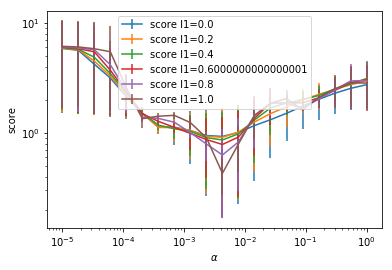

In [20]:
plot_cv_results2(cv_res)

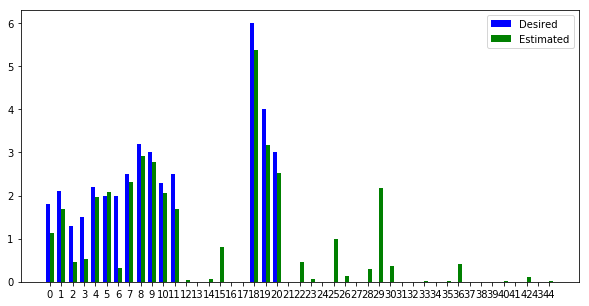

In [21]:
ana.plot_rates_bar(desired_rates, lsq_rates)

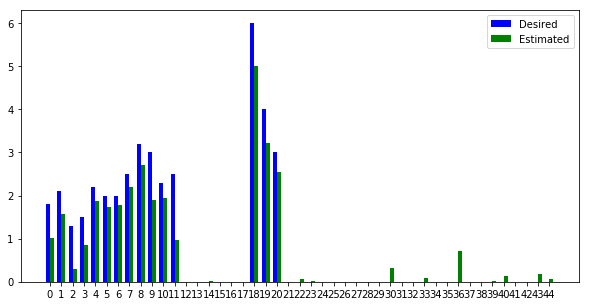

In [22]:
ana.plot_rates_bar(desired_rates, est_rates)